In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

pd.set_option('max_columns', None)

from tqdm.notebook import tqdm

import gc
from collections import defaultdict

from sklearn.metrics import roc_auc_score

from gensim.models import Word2Vec

from bitarray import bitarray

import lightgbm as lgb

%matplotlib inline
import seaborn as sns

In [2]:
train_pickle = '/home/user01/kaggle/riiid/cv1_train.pickle'
valid_pickle = '/home/user01/kaggle/riiid/cv1_valid.pickle'

question_file = '/home/user01/kaggle/riiid/questions.csv'
lecture_file = '/home/user01/kaggle/riiid/lectures.csv'

In [3]:
!mkdir -pv ./upload_cache_new

In [4]:
%%time

# read data

field_needed = ['row_id', 'user_id', 'content_id', 
                'content_type_id', 'task_container_id',
                'answered_correctly', 'prior_question_elapsed_time', 
                'prior_question_had_explanation', 'timestamp']

train = pd.read_pickle(train_pickle)[field_needed]
valid = pd.read_pickle(valid_pickle)[field_needed]
    
train = train.loc[train.content_type_id == False].reset_index(drop=True)
valid = valid.loc[valid.content_type_id == False].reset_index(drop=True)

train['prior_question_had_explanation'].fillna(False, inplace=True)
valid['prior_question_had_explanation'].fillna(False, inplace=True)
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('int8')
valid['prior_question_had_explanation'] = valid['prior_question_had_explanation'].astype('int8')

print(train.shape, valid.shape)

(96817414, 9) (2453886, 9)
CPU times: user 5.64 s, sys: 5.37 s, total: 11 s
Wall time: 11 s


In [5]:
train.head()

,row_id,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,timestamp
0,32933156,705741139,128,0,0,1,NaN,0,0
1,32933157,705741139,7860,0,1,1,16000.0,0,20666
2,32933158,705741139,7922,0,2,1,19000.0,0,39172
3,32933159,705741139,156,0,3,1,17000.0,0,58207
4,32933160,705741139,51,0,4,1,17000.0,0,75779


In [6]:
valid.head()

,row_id,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,timestamp
0,45253,1186307,4451,0,370,1,10000.0,1,2146476402
1,41038234,871981876,1278,0,3,0,26000.0,0,87403
2,56086085,1189905495,5604,0,1991,0,3000.0,1,41201916980
3,91995999,1951897185,8534,0,504,0,47000.0,1,4916060626
4,99237056,2105538840,5631,0,1,1,21000.0,0,33806


In [7]:
%%time

# answered correctly average for each content

content_df = train[['content_id', 'answered_correctly']].groupby(['content_id']).agg(['mean', 'var']).reset_index()
content_df.columns = ['content_id', 'answered_correctly_avg_c', 'answered_correctly_var_c']
content_df.head()

CPU times: user 4.42 s, sys: 1.47 s, total: 5.89 s
Wall time: 5.89 s


,content_id,answered_correctly_avg_c,answered_correctly_var_c
0,0,0.907334,0.084092
1,1,0.890571,0.097468
2,2,0.554213,0.247067
3,3,0.779386,0.171951
4,4,0.613970,0.237019


In [8]:
# lectures

lecture_df = pd.read_csv(lecture_file)
lecture_df.rename(columns={'lecture_id': 'content_id', 'part': 'lecture_part'}, inplace=True)
content_df = content_df.merge(lecture_df[['content_id', 'lecture_part']], how='left')

print(content_df.shape)
content_df.head()

(13523, 4)


,content_id,answered_correctly_avg_c,answered_correctly_var_c,lecture_part
0,0,0.907334,0.084092,NaN
1,1,0.890571,0.097468,NaN
2,2,0.554213,0.247067,NaN
3,3,0.779386,0.171951,NaN
4,4,0.613970,0.237019,NaN


In [9]:
%%time

train = pd.merge(train, content_df, on=['content_id'], how="left")
valid = pd.merge(valid, content_df, on=['content_id'], how="left")

CPU times: user 21.7 s, sys: 5.66 s, total: 27.3 s
Wall time: 27.3 s


In [10]:
train.head()

,row_id,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,timestamp,answered_correctly_avg_c,answered_correctly_var_c,lecture_part
0,32933156,705741139,128,0,0,1,NaN,0,0,0.966887,0.032018,NaN
1,32933157,705741139,7860,0,1,1,16000.0,0,20666,0.954720,0.043232,NaN
2,32933158,705741139,7922,0,2,1,19000.0,0,39172,0.953161,0.044647,NaN
3,32933159,705741139,156,0,3,1,17000.0,0,58207,0.932764,0.062719,NaN
4,32933160,705741139,51,0,4,1,17000.0,0,75779,0.930161,0.064964,NaN


In [11]:
%%time

# question

def addFeatures(_train, _questions):
    
    train_questions_only_df = _train[_train['answered_correctly']!=-1]
    
    grouped_by_content_df = train_questions_only_df.groupby('content_id')
    content_answers_df = grouped_by_content_df.agg({'answered_correctly': ['mean', 'count'] }).copy()
    content_answers_df.columns = ['mean_answered_correctly_content', 'question_asked']
    
    questions_df = _questions.merge(content_answers_df, left_on = 'question_id', right_on = 'content_id', how = 'left')
    bundle_dict = questions_df['bundle_id'].value_counts().to_dict()
    questions_df['right_answers'] = questions_df['mean_answered_correctly_content'] * questions_df['question_asked']
    questions_df['bundle_size'] = questions_df['bundle_id'].apply(lambda x: bundle_dict[x])

    grouped_by_bundle_df = questions_df.groupby('bundle_id')
    bundle_answers_df = grouped_by_bundle_df.agg({'right_answers': 'sum', 'question_asked': 'sum'}).copy()
    bundle_answers_df.columns = ['bundle_rignt_answers', 'bundle_questions_asked']
    bundle_answers_df['bundle_accuracy'] = bundle_answers_df['bundle_rignt_answers'] / bundle_answers_df['bundle_questions_asked']

    grouped_by_part_df = questions_df.groupby('part')
    part_answers_df = grouped_by_part_df.agg({'right_answers': 'sum', 'question_asked': 'sum'}).copy()
    part_answers_df.columns = ['part_rignt_answers', 'part_questions_asked']
    part_answers_df['part_accuracy'] = part_answers_df['part_rignt_answers'] / part_answers_df['part_questions_asked']

    return questions_df, bundle_answers_df, part_answers_df


questions_df = pd.read_csv(question_file)
questions_df, bundle_answers_df, part_answers_df = addFeatures(train, questions_df)

questions_df = pd.merge(questions_df,
                        bundle_answers_df,
                        on='bundle_id',
                        how='left')

questions_df = pd.merge(questions_df,
                        part_answers_df,
                        on='part',
                        how='left')

questions_df.rename(columns={'question_id': 'content_id'}, inplace=True)

questions_df['LorR'] = questions_df['part'].apply(lambda x: 1 if x >=5 else 0)

tag = questions_df["tags"].str.split(" ", n=10, expand=True)
tag.columns = ['tag1', 'tag2', 'tag3', 'tag4', 'tag5', 'tag6']
questions_df = pd.concat([questions_df, tag], axis=1)
questions_df['tag1'] = pd.to_numeric(questions_df['tag1'], errors='coerce')
questions_df['tag1'] = questions_df['tag1'].fillna(-1).astype(int)
questions_df.drop(['tag2', 'tag3', 'tag4', 'tag5', 'tag6', 'bundle_id'], axis=1, inplace=True)

tag1_agg = questions_df.groupby('tag1')['mean_answered_correctly_content'].agg(['mean', 'var'])
questions_df['tag1_answered_correctly_mean'] = questions_df['tag1'].map(tag1_agg['mean'])
questions_df['tag1_answered_correctly_var'] = questions_df['tag1'].map(tag1_agg['var'])
questions_df['tag1_answered_correctly_mean'] = questions_df.tag1_answered_correctly_mean.astype('float16')
questions_df['tag1_answered_correctly_var'] = questions_df.tag1_answered_correctly_var.astype('float16')

questions_df.set_index('content_id')

print(questions_df.shape)
questions_df.head()

(13523, 18)
CPU times: user 18.8 s, sys: 4.84 s, total: 23.7 s
Wall time: 23.7 s


,content_id,correct_answer,part,tags,mean_answered_correctly_content,question_asked,right_answers,bundle_size,bundle_rignt_answers,bundle_questions_asked,bundle_accuracy,part_rignt_answers,part_questions_asked,part_accuracy,LorR,tag1,tag1_answered_correctly_mean,tag1_answered_correctly_var
0,0,0,1,51 131 162 38,0.907334,6777,6149.0,1,6149.0,6777,0.907334,5425569.0,7276830,0.745595,0,51,0.838379,0.017258
1,1,1,1,131 36 81,0.890571,7265,6470.0,1,6470.0,7265,0.890571,5425569.0,7276830,0.745595,0,131,0.850586,0.017212
2,2,0,1,131 101 162 92,0.554213,43781,24264.0,1,24264.0,43781,0.554213,5425569.0,7276830,0.745595,0,131,0.850586,0.017212
3,3,0,1,131 149 162 29,0.779386,22451,17498.0,1,17498.0,22451,0.779386,5425569.0,7276830,0.745595,0,131,0.850586,0.017212
4,4,3,1,131 5 162 38,0.613970,30881,18960.0,1,18960.0,30881,0.613970,5425569.0,7276830,0.745595,0,131,0.850586,0.017212


In [12]:
# embedding 函数

def emb(df, c1, c2, emb_size=2):
    
    tmp = df.groupby(c1, as_index=False)[c2].agg(
        {'{}_{}_list'.format(c1, c2): list})
    sentences = tmp['{}_{}_list'.format(c1, c2)].values.tolist()
    del tmp['{}_{}_list'.format(c1, c2)]

    words = []
    for i in range(len(sentences)):
        words += sentences[i]
        sentences[i] = [str(x) for x in sentences[i]]
    words = list(set(words))

    model = Word2Vec(sentences, 
                     size=emb_size, 
                     window=3,
                     min_count=1, 
                     sg=0, 
                     hs=1, 
                     seed=2020)

    emb_matrix = []
    for w in words:
        w = str(w)
        if w in model:
            emb_matrix.append(model[w])
        else:
            emb_matrix.append([0] * emb_size)

    df_emb = pd.DataFrame(emb_matrix)
    df_emb.columns = ['{}_emb_{}'.format(
        c2, i) for i in range(emb_size)]

    df_emb[c2] = words

    del model, emb_matrix, sentences
    return df_emb


df_emb = emb(questions_df, 'content_id', 'tags')
questions_df = questions_df.merge(df_emb, on='tags', how='left')
questions_df.drop(['tags'], axis=1, inplace=True)

del df_emb
gc.collect()

questions_df.head()

,content_id,correct_answer,part,mean_answered_correctly_content,question_asked,right_answers,bundle_size,bundle_rignt_answers,bundle_questions_asked,bundle_accuracy,part_rignt_answers,part_questions_asked,part_accuracy,LorR,tag1,tag1_answered_correctly_mean,tag1_answered_correctly_var,tags_emb_0,tags_emb_1
0,0,0,1,0.907334,6777,6149.0,1,6149.0,6777,0.907334,5425569.0,7276830,0.745595,0,51,0.838379,0.017258,0.179532,0.141397
1,1,1,1,0.890571,7265,6470.0,1,6470.0,7265,0.890571,5425569.0,7276830,0.745595,0,131,0.850586,0.017212,-0.196008,-0.232887
2,2,0,1,0.554213,43781,24264.0,1,24264.0,43781,0.554213,5425569.0,7276830,0.745595,0,131,0.850586,0.017212,0.034004,-0.229731
3,3,0,1,0.779386,22451,17498.0,1,17498.0,22451,0.779386,5425569.0,7276830,0.745595,0,131,0.850586,0.017212,0.152637,-0.025414
4,4,3,1,0.613970,30881,18960.0,1,18960.0,30881,0.613970,5425569.0,7276830,0.745595,0,131,0.850586,0.017212,0.153832,-0.154031


In [13]:
%%time

qcols = [col for col in questions_df.columns if col not in ['correct_answer', 
                                                            'mean_answered_correctly_content']]

train = pd.merge(train, 
                 questions_df[qcols], 
                 on='content_id', 
                 how='left')

valid = pd.merge(valid, 
                 questions_df[qcols], 
                 on='content_id',
                 how='left')

CPU times: user 35.9 s, sys: 21.1 s, total: 56.9 s
Wall time: 56.9 s


In [14]:
train.head()

,row_id,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,timestamp,answered_correctly_avg_c,answered_correctly_var_c,lecture_part,part,question_asked,right_answers,bundle_size,bundle_rignt_answers,bundle_questions_asked,bundle_accuracy,part_rignt_answers,part_questions_asked,part_accuracy,LorR,tag1,tag1_answered_correctly_mean,tag1_answered_correctly_var,tags_emb_0,tags_emb_1
0,32933156,705741139,128,0,0,1,NaN,0,0,0.966887,0.032018,NaN,1,19056,18425.0,1,18425.0,19056,0.966887,5425569.0,7276830,0.745595,0,131,0.850586,0.017212,-0.007187,0.090353
1,32933157,705741139,7860,0,1,1,16000.0,0,20666,0.954720,0.043232,NaN,1,21135,20178.0,1,20178.0,21135,0.954720,5425569.0,7276830,0.745595,0,131,0.850586,0.017212,-0.038487,-0.097879
2,32933158,705741139,7922,0,2,1,19000.0,0,39172,0.953161,0.044647,NaN,1,18852,17969.0,1,17969.0,18852,0.953161,5425569.0,7276830,0.745595,0,131,0.850586,0.017212,-0.007187,0.090353
3,32933159,705741139,156,0,3,1,17000.0,0,58207,0.932764,0.062719,NaN,1,21878,20407.0,1,20407.0,21878,0.932764,5425569.0,7276830,0.745595,0,131,0.850586,0.017212,0.106040,-0.152273
4,32933160,705741139,51,0,4,1,17000.0,0,75779,0.930161,0.064964,NaN,1,23454,21816.0,1,21816.0,23454,0.930161,5425569.0,7276830,0.745595,0,131,0.850586,0.017212,-0.220193,0.188346


In [15]:
%%time

# 静态特征

use_cols = ['user_id', 'content_id', 'part', 'tag1']

df = pd.concat([train[use_cols], valid[use_cols]])

df['c_question_count_percent'] = df.groupby(['content_id'])['content_id'].transform('count') / len(df)
df['c_question_part_percent'] = df.groupby(['part'])['part'].transform('count') / len(df)
df['c_question_tag1_percent'] = df.groupby(['tag1'])['tag1'].transform('count') / len(df)
df['c_question_unique_users_seen'] = df.groupby(['content_id'])['user_id'].transform('nunique')

df = df.drop_duplicates(subset=['content_id'])
gc.collect()

print(df.shape)
df.head()

(13523, 8)
CPU times: user 1min 3s, sys: 17 s, total: 1min 20s
Wall time: 1min 17s


,user_id,content_id,part,tag1,c_question_count_percent,c_question_part_percent,c_question_tag1_percent,c_question_unique_users_seen
0,705741139,128,1,131,0.000198,0.075093,0.041839,19260
1,705741139,7860,1,131,0.000219,0.075093,0.041839,21261
2,705741139,7922,1,131,0.000196,0.075093,0.041839,19065
3,705741139,156,1,131,0.000227,0.075093,0.041839,21908
4,705741139,51,1,131,0.000243,0.075093,0.041839,23373


In [16]:
use_cols = ['content_id', 'c_question_count_percent', 
            'c_question_part_percent', 'c_question_tag1_percent',
            'c_question_unique_users_seen']

train = pd.merge(train, df[use_cols], on='content_id', how='left')
valid = pd.merge(valid, df[use_cols], on='content_id', how='left')

print(train.shape, valid.shape)
train.head()

(96817414, 32) (2453886, 32)


,row_id,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,timestamp,answered_correctly_avg_c,answered_correctly_var_c,lecture_part,part,question_asked,right_answers,bundle_size,bundle_rignt_answers,bundle_questions_asked,bundle_accuracy,part_rignt_answers,part_questions_asked,part_accuracy,LorR,tag1,tag1_answered_correctly_mean,tag1_answered_correctly_var,tags_emb_0,tags_emb_1,c_question_count_percent,c_question_part_percent,c_question_tag1_percent,c_question_unique_users_seen
0,32933156,705741139,128,0,0,1,NaN,0,0,0.966887,0.032018,NaN,1,19056,18425.0,1,18425.0,19056,0.966887,5425569.0,7276830,0.745595,0,131,0.850586,0.017212,-0.007187,0.090353,0.000198,0.075093,0.041839,19260
1,32933157,705741139,7860,0,1,1,16000.0,0,20666,0.954720,0.043232,NaN,1,21135,20178.0,1,20178.0,21135,0.954720,5425569.0,7276830,0.745595,0,131,0.850586,0.017212,-0.038487,-0.097879,0.000219,0.075093,0.041839,21261
2,32933158,705741139,7922,0,2,1,19000.0,0,39172,0.953161,0.044647,NaN,1,18852,17969.0,1,17969.0,18852,0.953161,5425569.0,7276830,0.745595,0,131,0.850586,0.017212,-0.007187,0.090353,0.000196,0.075093,0.041839,19065
3,32933159,705741139,156,0,3,1,17000.0,0,58207,0.932764,0.062719,NaN,1,21878,20407.0,1,20407.0,21878,0.932764,5425569.0,7276830,0.745595,0,131,0.850586,0.017212,0.106040,-0.152273,0.000227,0.075093,0.041839,21908
4,32933160,705741139,51,0,4,1,17000.0,0,75779,0.930161,0.064964,NaN,1,23454,21816.0,1,21816.0,23454,0.930161,5425569.0,7276830,0.745595,0,131,0.850586,0.017212,-0.220193,0.188346,0.000243,0.075093,0.041839,23373


In [17]:
questions_df = pd.merge(questions_df, df[['content_id',
                                          'c_question_count_percent', 
                                          'c_question_part_percent',
                                          'c_question_tag1_percent',
                                          'c_question_unique_users_seen']], on='content_id', how='left')

print(questions_df.shape)
questions_df.head()

(13523, 23)


,content_id,correct_answer,part,mean_answered_correctly_content,question_asked,right_answers,bundle_size,bundle_rignt_answers,bundle_questions_asked,bundle_accuracy,part_rignt_answers,part_questions_asked,part_accuracy,LorR,tag1,tag1_answered_correctly_mean,tag1_answered_correctly_var,tags_emb_0,tags_emb_1,c_question_count_percent,c_question_part_percent,c_question_tag1_percent,c_question_unique_users_seen
0,0,0,1,0.907334,6777,6149.0,1,6149.0,6777,0.907334,5425569.0,7276830,0.745595,0,51,0.838379,0.017258,0.179532,0.141397,0.000070,0.075093,0.003259,6380
1,1,1,1,0.890571,7265,6470.0,1,6470.0,7265,0.890571,5425569.0,7276830,0.745595,0,131,0.850586,0.017212,-0.196008,-0.232887,0.000075,0.075093,0.041839,6829
2,2,0,1,0.554213,43781,24264.0,1,24264.0,43781,0.554213,5425569.0,7276830,0.745595,0,131,0.850586,0.017212,0.034004,-0.229731,0.000452,0.075093,0.041839,38322
3,3,0,1,0.779386,22451,17498.0,1,17498.0,22451,0.779386,5425569.0,7276830,0.745595,0,131,0.850586,0.017212,0.152637,-0.025414,0.000231,0.075093,0.041839,20643
4,4,3,1,0.613970,30881,18960.0,1,18960.0,30881,0.613970,5425569.0,7276830,0.745595,0,131,0.850586,0.017212,0.153832,-0.154031,0.000320,0.075093,0.041839,29006


In [18]:
train.fillna(-1, inplace=True)
valid.fillna(-1, inplace=True)

use_cols = ['user_id', 'content_type_id', 'answered_correctly', 
            'part', 'tag1', 'timestamp', 'task_container_id',
            'prior_question_had_explanation', 'LorR', 'content_id']

train[use_cols] = train[use_cols].astype('int')
valid[use_cols] = valid[use_cols].astype('int')

In [19]:
from collections import OrderedDict

class LRUCache(OrderedDict):

    def __init__(self, capacity=8000000):
        self.capacity = capacity
        self.cache = OrderedDict()
     

    def get(self,key):
        if key in self.cache:
            value = self.cache.pop(key)
            self.cache[key] = value
        else:
            value = -1
         
        return value
     

    def set(self,key,value):
        if key in self.cache:
            value = self.cache.pop(key)
            self.cache[key] = value
        else:
            if len(self.cache) == self.capacity:
                self.cache.popitem(last = False)
                self.cache[key] = value
            else:
                self.cache[key] = value
                
                
lru_cache = LRUCache()

In [20]:
def add_user_feats(df,
                   u_answered_correctly_count_dict,                     # 用户答对的次数
                   u_answered_count_dict,                               # 用户作答的次数
                   u_question_part_correctly_count_dict,                # 用户作答 part 类型题目且答对的次数
                   u_question_part_count_dict,                          # 用户作答 part 类型题目的次数
                   u_question_tag1_correctly_count_dict,                # 用户作答 tag1 标签题目且答对的次数
                   u_question_tag1_count_dict,                          # 用户作答 tag1 标签题目的次数
                   u_prior_question_correctly_timestamp_dict,           # 用户上次正确作答的时间戳
                   u_prior2_question_correctly_timestamp_dict,          # 用户上次正确作答的时间戳
                   u_prior3_question_correctly_timestamp_dict,          # 用户上次正确作答的时间戳
                   u_prior_question_timestamp_dict,                     # 用户上次作答的时间戳
                   u_prior2_question_timestamp_dict,                    # 用户上上次作答的时间戳
                   u_prior3_question_timestamp_dict,                    # 用户上上上次作答的时间戳
                   u_prior4_question_timestamp_dict,                    # 用户上上上上次作答的时间戳
                   u_prior_lecture_timestamp_dict,                      # 用户上次观看 lecture 的时间戳
                   u_prior2_lecture_timestamp_dict,                     # 用户上上次观看 lecture 的时间戳
                   u_task_container_id_dict,                            # 用户 task id
                   u_prior_question_explanation_count_dict,             # 用户上次查看问题解答的次数
                   u_prior_question_explanation_correctly_count_dict,   # 用户上次查看问题解答后正确答对的次数
                   u_question_listening_correctly_count_dict,           # 用户作答听力题目且答对的次数
                   u_question_reading_correctly_count_dict,             # 用户作答阅读题目且答对的次数
                   u_question_listening_count_dict,                     # 用户作答听力题目且答对的次数
                   u_question_reading_count_dict,                       # 用户作答阅读题目且答对的次数
                   u_question_incorrect_timestamp_dict,                 # 用户上次答错的时间戳
                   u_question_incorrect_timestamp2_dict,                # 用户上上次答错的时间戳
                   u_question_incorrect_timestamp3_dict,                # 用户上上上次答错的时间戳
                   u_question_seen_dict,                                # 这道题用户是否做过
                   u_question_part_correct_timestamp_dict,              # 用户上次该 part 答对的时间戳
                   u_question_part_incorrect_timestamp_dict,            # 用户上次该 part 答错的时间戳
                  ):
    
    uacc = np.zeros(len(df), dtype=np.int32)
    uac = np.zeros(len(df), dtype=np.int32)
    uqpcc = np.zeros(len(df), dtype=np.int32)
    uqpc = np.zeros(len(df), dtype=np.int32)
    uqt1cc = np.zeros(len(df), dtype=np.int32)
    uqt1c = np.zeros(len(df), dtype=np.int32)
    upqct = np.zeros(len(df), dtype=np.int32)
    up2qct = np.zeros(len(df), dtype=np.int32)
    up3qct = np.zeros(len(df), dtype=np.int32)
    upqt = np.zeros(len(df), dtype=np.int32)
    up2qt = np.zeros(len(df), dtype=np.int32)
    up3qt = np.zeros(len(df), dtype=np.int32)
    up4qt = np.zeros(len(df), dtype=np.int32)
    uplt = np.zeros(len(df), dtype=np.int32)
    up2lt = np.zeros(len(df), dtype=np.int32)
    utci = np.zeros(len(df), dtype=np.int32)
    upqec = np.zeros(len(df), dtype=np.int32)
    upqecc = np.zeros(len(df), dtype=np.int32)
    uqlcc = np.zeros(len(df), dtype=np.int32)
    uqrcc = np.zeros(len(df), dtype=np.int32)
    uqlc = np.zeros(len(df), dtype=np.int32)
    uqrc = np.zeros(len(df), dtype=np.int32)
    uqict = np.zeros(len(df), dtype=np.int32)
    uqict2 = np.zeros(len(df), dtype=np.int32)
    uqict3 = np.zeros(len(df), dtype=np.int32)
    uqs = np.zeros(len(df), dtype=np.int32)
    uqn = np.zeros(len(df), dtype=np.int32)        # 用户一共做了多少道不同的题目
    uqpct = np.zeros(len(df), dtype=np.int32)
    uqpict = np.zeros(len(df), dtype=np.int32)
    uct = np.zeros(len(df), dtype=np.int32)
    
    for cnt, row in enumerate(tqdm(df[['user_id',
                                       'content_type_id',
                                       'answered_correctly', 
                                       'part',
                                       'tag1',
                                       'timestamp',
                                       'task_container_id',
                                       'prior_question_had_explanation',
                                       'LorR',
                                       'content_id']].values)):
        user_id = row[0]
        content_type = row[1]
        answered_correctly = row[2]
        question_part = row[3]
        question_tag1 = row[4]
        timestamp = row[5]
        task_container_id = row[6]
        prior_question_had_explanation = row[7]
        LorR = row[8]
        content_id = row[9]
        
        uid_part = str(user_id) + '_' + str(question_part)
        uid_tag1 = str(user_id) + '_' + str(question_tag1)
        uid_cid = int(user_id) + int(content_id)*10e10
        
        uct[cnt] = timestamp - lru_cache.get(uid_cid)
        uacc[cnt] = u_answered_correctly_count_dict[user_id]
        uac[cnt] = u_answered_count_dict[user_id]
        uqpcc[cnt] = u_question_part_correctly_count_dict[uid_part]
        uqpc[cnt] = u_question_part_count_dict[uid_part]
        uqt1cc[cnt] = u_question_tag1_correctly_count_dict[uid_tag1]
        uqt1c[cnt] = u_question_tag1_count_dict[uid_tag1]
        upqct[cnt] = timestamp - u_prior_question_correctly_timestamp_dict[user_id]
        up2qct[cnt] = timestamp - u_prior2_question_correctly_timestamp_dict[user_id]
        up3qct[cnt] = timestamp - u_prior3_question_correctly_timestamp_dict[user_id]
        upqt[cnt] = timestamp - u_prior_question_timestamp_dict[user_id]
        up2qt[cnt] = timestamp - u_prior2_question_timestamp_dict[user_id]
        up3qt[cnt] = timestamp - u_prior3_question_timestamp_dict[user_id]
        up4qt[cnt] = timestamp - u_prior4_question_timestamp_dict[user_id]
        uplt[cnt] = timestamp - u_prior_lecture_timestamp_dict[user_id]
        up2lt[cnt] = timestamp - u_prior2_lecture_timestamp_dict[user_id]
        utci[cnt] = task_container_id - u_task_container_id_dict[user_id]
        upqec[cnt] = u_prior_question_explanation_count_dict[user_id]
        upqecc[cnt] = u_prior_question_explanation_correctly_count_dict[user_id]
        uqlcc[cnt] = u_question_listening_correctly_count_dict[user_id]
        uqrcc[cnt] = u_question_reading_correctly_count_dict[user_id]
        uqlc[cnt] = u_question_listening_count_dict[user_id]
        uqrc[cnt] = u_question_reading_count_dict[user_id]
        uqict[cnt] = timestamp - u_question_incorrect_timestamp_dict[user_id]
        uqict2[cnt] = timestamp - u_question_incorrect_timestamp2_dict[user_id]
        uqict3[cnt] = timestamp - u_question_incorrect_timestamp3_dict[user_id]
        uqpct[cnt] = timestamp - u_question_part_correct_timestamp_dict[uid_part]
        uqpict[cnt] = timestamp - u_question_part_incorrect_timestamp_dict[uid_part]
        if content_type == 0:
            if user_id not in u_question_seen_dict:
                u_question_seen_dict[user_id] = bitarray('0'*14000, endian='little')
            uqs[cnt] = u_question_seen_dict[user_id][content_id]
            uqn[cnt] = u_question_seen_dict[user_id].count()
        
        if content_type == 0:
                
            if answered_correctly == 1:
                u_prior3_question_correctly_timestamp_dict[user_id] = u_prior2_question_correctly_timestamp_dict[user_id]
                u_prior2_question_correctly_timestamp_dict[user_id] = u_prior_question_correctly_timestamp_dict[user_id]
                u_prior_question_correctly_timestamp_dict[user_id] = timestamp
                u_prior_question_explanation_correctly_count_dict[user_id] += 1
                u_question_part_correct_timestamp_dict[uid_part] = timestamp
                if LorR == 0:
                    u_question_listening_correctly_count_dict[user_id] += 1
                else:
                    u_question_reading_correctly_count_dict[user_id] += 1
            else:
                u_question_incorrect_timestamp3_dict[user_id] = u_question_incorrect_timestamp2_dict[user_id]
                u_question_incorrect_timestamp2_dict[user_id] = u_question_incorrect_timestamp_dict[user_id]
                u_question_incorrect_timestamp_dict[user_id] = timestamp
                u_question_part_incorrect_timestamp_dict[uid_part] = timestamp
                
            u_answered_correctly_count_dict[user_id] += answered_correctly
            u_answered_count_dict[user_id] += 1
            u_question_part_correctly_count_dict[uid_part] += answered_correctly
            u_question_part_count_dict[uid_part] += 1
            u_question_tag1_correctly_count_dict[uid_tag1] += answered_correctly
            u_question_tag1_count_dict[uid_tag1] += 1
            u_prior4_question_timestamp_dict[user_id] = u_prior3_question_timestamp_dict[user_id]
            u_prior3_question_timestamp_dict[user_id] = u_prior2_question_timestamp_dict[user_id]
            u_prior2_question_timestamp_dict[user_id] = u_prior_question_timestamp_dict[user_id]
            u_prior_question_timestamp_dict[user_id] = timestamp
            u_task_container_id_dict[user_id] = task_container_id
            u_prior_question_explanation_count_dict[user_id] += prior_question_had_explanation
            if LorR == 0:
                u_question_listening_count_dict[user_id] += 1
            else:
                u_question_reading_count_dict[user_id] += 1
            u_question_seen_dict[user_id][content_id] = 1
            lru_cache.set(uid_cid, timestamp)
            
        else:
            u_prior2_lecture_timestamp_dict[user_id] = u_prior_lecture_timestamp_dict[user_id]
            u_prior_lecture_timestamp_dict[user_id] = timestamp
        
        
    user_feats_df = pd.DataFrame({'u_answered_correctly_count': uacc, 
                                  'u_answered_count': uac,
                                  'u_question_part_correctly_count': uqpcc,
                                  'u_question_part_count': uqpc,
                                  'u_question_tag1_correctly_count': uqt1cc,
                                  'u_question_tag1_count': uqt1c,
                                  'u_prior_question_correctly_timestamp_diff': upqct,
                                  'u_prior_question_correctly_timestamp_diff2': up2qct,
                                  'u_prior_question_correctly_timestamp_diff3': up3qct,
                                  'u_prior_question_timestamp_diff': upqt,
                                  'u_prior_question_timestamp_diff2': up2qt,
                                  'u_prior_question_timestamp_diff3': up3qt,
                                  'u_prior_question_timestamp_diff4': up4qt,
                                  'u_prior_lecture_timestamp_diff': uplt,
                                  'u_prior2_lecture_timestamp_diff': up2lt,
                                  'u_task_container_id_diff': utci,
                                  'u_prior_question_explanation_count': upqec,
                                  'u_prior_question_explanation_correctly_count': upqecc,
                                  'u_question_listening_correctly_count': uqlcc,
                                  'u_question_reading_correctly_count': uqrcc,
                                  'u_question_listening_count': uqlc,
                                  'u_question_reading_count': uqrc,
                                  'u_question_incorrect_timestamp_diff': uqict,
                                  'u_question_incorrect_timestamp_diff2': uqict2,
                                  'u_question_incorrect_timestamp_diff3': uqict3,
                                  'u_question_seen': uqs,
                                  'u_question_nunique': uqn,
                                  'u_question_part_correct_timestamp_diff': uqpct,
                                  'u_question_part_incorrect_timestamp_diff': uqpict,
                                  'uc_question_timestamp_diff': uct,
                                 })
    
    user_feats_df['u_answered_correctly_avg'] = user_feats_df['u_answered_correctly_count'] / user_feats_df['u_answered_count']
    user_feats_df['u_question_part_correctly_avg'] = user_feats_df['u_question_part_correctly_count'] / user_feats_df['u_question_part_count']
    user_feats_df['u_question_tag1_correctly_avg'] = user_feats_df['u_question_tag1_correctly_count'] / user_feats_df['u_question_tag1_count']
    user_feats_df['u_prior_question_timestamp_diff_2_1'] = user_feats_df['u_prior_question_timestamp_diff2'] - user_feats_df['u_prior_question_timestamp_diff']
    user_feats_df['u_prior_question_timestamp_diff_3_2'] = user_feats_df['u_prior_question_timestamp_diff3'] - user_feats_df['u_prior_question_timestamp_diff2']
    user_feats_df['u_prior_question_timestamp_diff_4_3'] = user_feats_df['u_prior_question_timestamp_diff4'] - user_feats_df['u_prior_question_timestamp_diff3']
    
    df = pd.concat([df, user_feats_df], axis=1)
    df['u_question_timestamp_diff']  = df['u_prior_question_timestamp_diff_2_1'] - df['prior_question_elapsed_time']
    df['u_question_timestamp_diff2']  = df['u_prior_question_timestamp_diff_3_2'] - df['prior_question_elapsed_time']
    df['u_question_timestamp_diff3']  = df['u_prior_question_timestamp_diff_4_3'] - df['prior_question_elapsed_time']
    df['u_listening_reading_ratio'] = df['u_question_listening_correctly_count'] / (1 + df['u_question_reading_correctly_count'])
    df['u_listening_correctly_avg'] = df['u_question_listening_correctly_count'] / (1 + df['u_question_listening_count'])
    df['u_reading_correctly_avg'] = df['u_question_reading_correctly_count'] / (1 + df['u_question_reading_count'])
    
    return df


def add_user_feats_without_update(df, 
                                  u_answered_correctly_count_dict, 
                                  u_answered_count_dict, 
                                  u_question_part_correctly_count_dict,
                                  u_question_part_count_dict,
                                  u_question_tag1_correctly_count_dict,
                                  u_question_tag1_count_dict,
                                  u_prior_question_correctly_timestamp_dict,
                                  u_prior2_question_correctly_timestamp_dict,
                                  u_prior3_question_correctly_timestamp_dict,
                                  u_prior_question_timestamp_dict,
                                  u_prior2_question_timestamp_dict,
                                  u_prior3_question_timestamp_dict,
                                  u_prior4_question_timestamp_dict,
                                  u_prior_lecture_timestamp_dict,
                                  u_prior2_lecture_timestamp_dict,
                                  u_task_container_id_dict,
                                  u_prior_question_explanation_count_dict,
                                  u_prior_question_explanation_correctly_count_dict,
                                  u_question_listening_correctly_count_dict,
                                  u_question_reading_correctly_count_dict,
                                  u_question_listening_count_dict,
                                  u_question_reading_count_dict,
                                  u_question_incorrect_timestamp_dict,
                                  u_question_incorrect_timestamp2_dict,
                                  u_question_incorrect_timestamp3_dict,
                                  u_question_seen_dict,
                                  u_question_part_correct_timestamp_dict,
                                  u_question_part_incorrect_timestamp_dict,
                                 ):
    
    uacc = np.zeros(len(df), dtype=np.int32)
    uac = np.zeros(len(df), dtype=np.int32)
    uqpcc = np.zeros(len(df), dtype=np.int32)
    uqpc = np.zeros(len(df), dtype=np.int32)
    uqt1cc = np.zeros(len(df), dtype=np.int32)
    uqt1c = np.zeros(len(df), dtype=np.int32)
    upqct = np.zeros(len(df), dtype=np.int32)
    up2qct = np.zeros(len(df), dtype=np.int32)
    up3qct = np.zeros(len(df), dtype=np.int32)
    upqt = np.zeros(len(df), dtype=np.int32)
    up2qt = np.zeros(len(df), dtype=np.int32)
    up3qt = np.zeros(len(df), dtype=np.int32)
    up4qt = np.zeros(len(df), dtype=np.int32)
    uplt = np.zeros(len(df), dtype=np.int32)
    up2lt = np.zeros(len(df), dtype=np.int32)
    utci = np.zeros(len(df), dtype=np.int32)
    upqec = np.zeros(len(df), dtype=np.int32)
    upqecc = np.zeros(len(df), dtype=np.int32)
    uqlcc = np.zeros(len(df), dtype=np.int32)
    uqrcc = np.zeros(len(df), dtype=np.int32)
    uqlc = np.zeros(len(df), dtype=np.int32)
    uqrc = np.zeros(len(df), dtype=np.int32)
    uqict = np.zeros(len(df), dtype=np.int32)
    uqict2 = np.zeros(len(df), dtype=np.int32)
    uqict3 = np.zeros(len(df), dtype=np.int32)
    uqs = np.zeros(len(df), dtype=np.int32)
    uqn = np.zeros(len(df), dtype=np.int32)
    uqpct = np.zeros(len(df), dtype=np.int32)
    uqpict = np.zeros(len(df), dtype=np.int32)
    uct = np.zeros(len(df), dtype=np.int32)
    
    for cnt, row in enumerate(df[['user_id',
                                  'content_type_id', 
                                  'part',
                                  'tag1',
                                  'timestamp',
                                  'task_container_id',
                                  'prior_question_had_explanation',
                                  'LorR',
                                  'content_id']].values):
        user_id = row[0]
        content_type = row[1]
        question_part = row[2]
        question_tag1 = row[3]
        timestamp = row[4]
        task_container_id = row[5]
        prior_question_had_explanation = row[6]
        LorR = row[7]
        content_id = row[8]
        
        uid_part = str(user_id) + '_' + str(question_part)
        uid_tag1 = str(user_id) + '_' + str(question_tag1)
        uid_cid = int(user_id) + int(content_id)*10e10
        
        uct[cnt] = timestamp - lru_cache.get(uid_cid)
        uacc[cnt] = u_answered_correctly_count_dict[user_id]
        uac[cnt] = u_answered_count_dict[user_id]
        uqpcc[cnt] = u_question_part_correctly_count_dict[uid_part]
        uqpc[cnt] = u_question_part_count_dict[uid_part]
        uqt1cc[cnt] = u_question_tag1_correctly_count_dict[uid_tag1]
        uqt1c[cnt] = u_question_tag1_count_dict[uid_tag1]
        upqct[cnt] = timestamp - u_prior_question_correctly_timestamp_dict[user_id]
        up2qct[cnt] = timestamp - u_prior2_question_correctly_timestamp_dict[user_id]
        up3qct[cnt] = timestamp - u_prior3_question_correctly_timestamp_dict[user_id]
        upqt[cnt] = timestamp - u_prior_question_timestamp_dict[user_id]
        up2qt[cnt] = timestamp - u_prior2_question_timestamp_dict[user_id]
        up3qt[cnt] = timestamp - u_prior3_question_timestamp_dict[user_id]
        up4qt[cnt] = timestamp - u_prior4_question_timestamp_dict[user_id]
        uplt[cnt] = timestamp - u_prior_lecture_timestamp_dict[user_id]
        up2lt[cnt] = timestamp - u_prior2_lecture_timestamp_dict[user_id]
        utci[cnt] = task_container_id - u_task_container_id_dict[user_id]
        upqec[cnt] = u_prior_question_explanation_count_dict[user_id]
        upqecc[cnt] = u_prior_question_explanation_correctly_count_dict[user_id]
        uqlcc[cnt] = u_question_listening_correctly_count_dict[user_id]
        uqrcc[cnt] = u_question_reading_correctly_count_dict[user_id]
        uqlc[cnt] = u_question_listening_count_dict[user_id]
        uqrc[cnt] = u_question_reading_count_dict[user_id]
        uqict[cnt] = timestamp - u_question_incorrect_timestamp_dict[user_id]
        uqict2[cnt] = timestamp - u_question_incorrect_timestamp2_dict[user_id]
        uqict3[cnt] = timestamp - u_question_incorrect_timestamp3_dict[user_id]
        uqpct[cnt] = timestamp - u_question_part_correct_timestamp_dict[uid_part]
        uqpict[cnt] = timestamp - u_question_part_incorrect_timestamp_dict[uid_part]
        if content_type == 0:
            if user_id not in u_question_seen_dict:
                u_question_seen_dict[user_id] = bitarray('0'*14000, endian='little')
            uqs[cnt] = u_question_seen_dict[user_id][content_id]
            uqn[cnt] = u_question_seen_dict[user_id].count()
        
    user_feats_df = pd.DataFrame({'u_answered_correctly_count': uacc, 
                                  'u_answered_count': uac,
                                  'u_question_part_correctly_count': uqpcc,
                                  'u_question_part_count': uqpc,
                                  'u_question_tag1_correctly_count': uqt1cc,
                                  'u_question_tag1_count': uqt1c,
                                  'u_prior_question_correctly_timestamp_diff': upqct,
                                  'u_prior_question_correctly_timestamp_diff2': up2qct,
                                  'u_prior_question_correctly_timestamp_diff3': up3qct,
                                  'u_prior_question_timestamp_diff': upqt,
                                  'u_prior_question_timestamp_diff2': up2qt,
                                  'u_prior_question_timestamp_diff3': up3qt,
                                  'u_prior_question_timestamp_diff4': up4qt,
                                  'u_prior_lecture_timestamp_diff': uplt,
                                  'u_prior2_lecture_timestamp_diff': up2lt,
                                  'u_task_container_id_diff': utci,
                                  'u_prior_question_explanation_count': upqec,
                                  'u_prior_question_explanation_correctly_count': upqecc,
                                  'u_question_listening_correctly_count': uqlcc,
                                  'u_question_reading_correctly_count': uqrcc,
                                  'u_question_listening_count': uqlc,
                                  'u_question_reading_count': uqrc,
                                  'u_question_incorrect_timestamp_diff': uqict,
                                  'u_question_incorrect_timestamp_diff2': uqict2,
                                  'u_question_incorrect_timestamp_diff3': uqict3,
                                  'u_question_seen': uqs,
                                  'u_question_nunique': uqn,
                                  'u_question_part_correct_timestamp_diff': uqpct,
                                  'u_question_part_incorrect_timestamp_diff': uqpict,
                                  'uc_question_timestamp_diff': uct,
                                  })
    
    user_feats_df['u_answered_correctly_avg'] = user_feats_df['u_answered_correctly_count'] / user_feats_df['u_answered_count']
    user_feats_df['u_question_part_correctly_avg'] = user_feats_df['u_question_part_correctly_count'] / user_feats_df['u_question_part_count']
    user_feats_df['u_question_tag1_correctly_avg'] = user_feats_df['u_question_tag1_correctly_count'] / user_feats_df['u_question_tag1_count']
    user_feats_df['u_prior_question_timestamp_diff_2_1'] = user_feats_df['u_prior_question_timestamp_diff2'] - user_feats_df['u_prior_question_timestamp_diff']
    user_feats_df['u_prior_question_timestamp_diff_3_2'] = user_feats_df['u_prior_question_timestamp_diff3'] - user_feats_df['u_prior_question_timestamp_diff2']
    user_feats_df['u_prior_question_timestamp_diff_4_3'] = user_feats_df['u_prior_question_timestamp_diff4'] - user_feats_df['u_prior_question_timestamp_diff3']
    
    df = pd.concat([df, user_feats_df], axis=1)
    df['u_question_timestamp_diff']  = df['u_prior_question_timestamp_diff_2_1'] - df['prior_question_elapsed_time']
    df['u_question_timestamp_diff2']  = df['u_prior_question_timestamp_diff_3_2'] - df['prior_question_elapsed_time']
    df['u_question_timestamp_diff3']  = df['u_prior_question_timestamp_diff_4_3'] - df['prior_question_elapsed_time']
    df['u_listening_reading_ratio'] = df['u_question_listening_correctly_count'] / (1 + df['u_question_reading_correctly_count'])
    df['u_listening_correctly_avg'] = df['u_question_listening_correctly_count'] / (1 + df['u_question_listening_count'])
    df['u_reading_correctly_avg'] = df['u_question_reading_correctly_count'] / (1 + df['u_question_reading_count'])
    
    return df


def update_user_feats(df, 
                      u_answered_correctly_count_dict,
                      u_answered_count_dict, 
                      u_question_part_correctly_count_dict,
                      u_question_part_count_dict,
                      u_question_tag1_correctly_count_dict,
                      u_question_tag1_count_dict,
                      u_prior_question_correctly_timestamp_dict,
                      u_prior2_question_correctly_timestamp_dict,
                      u_prior3_question_correctly_timestamp_dict,
                      u_prior_question_timestamp_dict,
                      u_prior2_question_timestamp_dict,
                      u_prior3_question_timestamp_dict,
                      u_prior4_question_timestamp_dict,
                      u_prior_lecture_timestamp_dict, 
                      u_prior2_lecture_timestamp_dict,
                      u_task_container_id_dict,
                      u_prior_question_explanation_count_dict,
                      u_prior_question_explanation_correctly_count_dict,
                      u_question_listening_correctly_count_dict, 
                      u_question_reading_correctly_count_dict,
                      u_question_listening_count_dict,
                      u_question_reading_count_dict,
                      u_question_incorrect_timestamp_dict,
                      u_question_incorrect_timestamp2_dict,
                      u_question_incorrect_timestamp3_dict,
                      u_question_seen_dict,
                      u_question_part_correct_timestamp_dict,
                      u_question_part_incorrect_timestamp_dict,
                     ):
    
    for cnt, row in enumerate(df[['user_id',
                                  'content_type_id',
                                  'answered_correctly', 
                                  'part',
                                  'tag1',
                                  'timestamp',
                                  'task_container_id',
                                  'prior_question_had_explanation',
                                  'LorR',
                                  'content_id']].values):
        user_id = row[0]
        content_type = row[1]
        answered_correctly = row[2]
        question_part = row[3]
        question_tag1 = row[4]
        timestamp = row[5]
        task_container_id = row[6]
        prior_question_had_explanation = row[7]
        LorR = row[8]
        content_id = row[9]
        
        uid_part = str(user_id) + '_' + str(question_part)
        uid_tag1 = str(user_id) + '_' + str(question_tag1)
        uid_cid = int(user_id) + int(content_id)*10e10
        
        if content_type == 0:
            
            if answered_correctly == 1:
                u_prior3_question_correctly_timestamp_dict[user_id] = u_prior2_question_correctly_timestamp_dict[user_id]
                u_prior2_question_correctly_timestamp_dict[user_id] = u_prior_question_correctly_timestamp_dict[user_id]
                u_prior_question_correctly_timestamp_dict[user_id] = timestamp
                u_prior_question_explanation_correctly_count_dict[user_id] += 1
                u_question_part_correct_timestamp_dict[uid_part] = timestamp
                if LorR == 0:
                    u_question_listening_correctly_count_dict[user_id] += 1
                else:
                    u_question_reading_correctly_count_dict[user_id] += 1
            else:
                u_question_incorrect_timestamp3_dict[user_id] = u_question_incorrect_timestamp2_dict[user_id]
                u_question_incorrect_timestamp2_dict[user_id] = u_question_incorrect_timestamp_dict[user_id]
                u_question_incorrect_timestamp_dict[user_id] = timestamp
                u_question_part_incorrect_timestamp_dict[uid_part] = timestamp
                
            u_answered_correctly_count_dict[user_id] += answered_correctly
            u_answered_count_dict[user_id] += 1
            u_question_part_correctly_count_dict[uid_part] += answered_correctly
            u_question_part_count_dict[uid_part] += 1
            u_question_tag1_correctly_count_dict[uid_tag1] += answered_correctly
            u_question_tag1_count_dict[uid_tag1] += 1
            u_prior4_question_timestamp_dict[user_id] = u_prior3_question_timestamp_dict[user_id]
            u_prior3_question_timestamp_dict[user_id] = u_prior2_question_timestamp_dict[user_id]
            u_prior2_question_timestamp_dict[user_id] = u_prior_question_timestamp_dict[user_id]
            u_prior_question_timestamp_dict[user_id] = timestamp
            u_task_container_id_dict[user_id] = task_container_id
            u_prior_question_explanation_count_dict[user_id] += prior_question_had_explanation
            if LorR == 0:
                u_question_listening_count_dict[user_id] += 1
            else:
                u_question_reading_count_dict[user_id] += 1
            u_question_seen_dict[user_id][content_id] = 1
            lru_cache.set(uid_cid, timestamp)
            
        else:
            u_prior2_lecture_timestamp_dict[user_id] = u_prior_lecture_timestamp_dict[user_id]
            u_prior_lecture_timestamp_dict[user_id] = timestamp

In [21]:
%%time

# user stats features with loops

u_answered_correctly_count_dict = defaultdict(int)
u_answered_count_dict = defaultdict(int)
u_question_part_correctly_count_dict = defaultdict(int)
u_question_part_count_dict = defaultdict(int)
u_question_tag1_correctly_count_dict = defaultdict(int)
u_question_tag1_count_dict = defaultdict(int)
u_question_tag2_correctly_count_dict = defaultdict(int)
u_question_tag2_count_dict = defaultdict(int)
u_prior_question_correctly_timestamp_dict = defaultdict(int)
u_prior2_question_correctly_timestamp_dict = defaultdict(int)
u_prior3_question_correctly_timestamp_dict = defaultdict(int)
u_prior_question_timestamp_dict = defaultdict(int)
u_prior2_question_timestamp_dict = defaultdict(int)
u_prior3_question_timestamp_dict = defaultdict(int)
u_prior4_question_timestamp_dict = defaultdict(int)
u_prior_lecture_timestamp_dict = defaultdict(int)
u_prior2_lecture_timestamp_dict = defaultdict(int)
u_task_container_id_dict = defaultdict(int)
u_prior_question_explanation_count_dict = defaultdict(int)
u_prior_question_explanation_correctly_count_dict = defaultdict(int)
u_question_listening_correctly_count_dict = defaultdict(int)
u_question_reading_correctly_count_dict = defaultdict(int) 
u_question_listening_count_dict = defaultdict(int)
u_question_reading_count_dict = defaultdict(int) 
u_question_incorrect_timestamp_dict = defaultdict(int)
u_question_incorrect_timestamp2_dict = defaultdict(int)
u_question_incorrect_timestamp3_dict = defaultdict(int)
u_question_seen_dict = defaultdict(int)
u_question_part_correct_timestamp_dict = defaultdict(int)
u_question_part_incorrect_timestamp_dict = defaultdict(int)

train = add_user_feats(train, 
                       u_answered_correctly_count_dict, u_answered_count_dict,
                       u_question_part_correctly_count_dict, u_question_part_count_dict,
                       u_question_tag1_correctly_count_dict, u_question_tag1_count_dict,
                       u_prior_question_correctly_timestamp_dict, u_prior2_question_correctly_timestamp_dict, 
                       u_prior3_question_correctly_timestamp_dict, u_prior_question_timestamp_dict,
                       u_prior2_question_timestamp_dict, u_prior3_question_timestamp_dict,
                       u_prior4_question_timestamp_dict, u_prior_lecture_timestamp_dict,
                       u_prior2_lecture_timestamp_dict, u_task_container_id_dict,
                       u_prior_question_explanation_count_dict, u_prior_question_explanation_correctly_count_dict,
                       u_question_listening_correctly_count_dict, u_question_reading_correctly_count_dict,
                       u_question_listening_count_dict, u_question_reading_count_dict,
                       u_question_incorrect_timestamp_dict, u_question_incorrect_timestamp2_dict,
                       u_question_incorrect_timestamp3_dict, u_question_seen_dict,
                       u_question_part_correct_timestamp_dict, u_question_part_incorrect_timestamp_dict,
                      )

valid = add_user_feats(valid, 
                       u_answered_correctly_count_dict, u_answered_count_dict,
                       u_question_part_correctly_count_dict, u_question_part_count_dict,
                       u_question_tag1_correctly_count_dict, u_question_tag1_count_dict,
                       u_prior_question_correctly_timestamp_dict, u_prior2_question_correctly_timestamp_dict,
                       u_prior3_question_correctly_timestamp_dict, u_prior_question_timestamp_dict,
                       u_prior2_question_timestamp_dict, u_prior3_question_timestamp_dict,
                       u_prior4_question_timestamp_dict, u_prior_lecture_timestamp_dict,
                       u_prior2_lecture_timestamp_dict, u_task_container_id_dict,
                       u_prior_question_explanation_count_dict, u_prior_question_explanation_correctly_count_dict,
                       u_question_listening_correctly_count_dict, u_question_reading_correctly_count_dict,
                       u_question_listening_count_dict, u_question_reading_count_dict,
                       u_question_incorrect_timestamp_dict, u_question_incorrect_timestamp2_dict,
                       u_question_incorrect_timestamp3_dict, u_question_seen_dict,
                       u_question_part_correct_timestamp_dict, u_question_part_incorrect_timestamp_dict,
                      )


CPU times: user 1h 28s, sys: 3min 34s, total: 1h 4min 3s
Wall time: 1h 3min 27s


In [22]:
prior_question_elapsed_time_mean = train.prior_question_elapsed_time.dropna().values.mean()
prior_question_elapsed_time_mean

25340.273

In [23]:
# fill with mean value for prior_question_elapsed_time
train['prior_question_elapsed_time'] = train.prior_question_elapsed_time.fillna(prior_question_elapsed_time_mean)
valid['prior_question_elapsed_time'] = valid.prior_question_elapsed_time.fillna(prior_question_elapsed_time_mean)

# changing dtype to avoid lightgbm error
# train['prior_question_had_explanation'] = train.prior_question_had_explanation.fillna(False).astype('int8')
# valid['prior_question_had_explanation'] = valid.prior_question_had_explanation.fillna(False).astype('int8')

In [24]:
train.head()

,row_id,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,timestamp,answered_correctly_avg_c,answered_correctly_var_c,lecture_part,part,question_asked,right_answers,bundle_size,bundle_rignt_answers,bundle_questions_asked,bundle_accuracy,part_rignt_answers,part_questions_asked,part_accuracy,LorR,tag1,tag1_answered_correctly_mean,tag1_answered_correctly_var,tags_emb_0,tags_emb_1,c_question_count_percent,c_question_part_percent,c_question_tag1_percent,c_question_unique_users_seen,u_answered_correctly_count,u_answered_count,u_question_part_correctly_count,u_question_part_count,u_question_tag1_correctly_count,u_question_tag1_count,u_prior_question_correctly_timestamp_diff,u_prior_question_correctly_timestamp_diff2,u_prior_question_correctly_timestamp_diff3,u_prior_question_timestamp_diff,u_prior_question_timestamp_diff2,u_prior_question_timestamp_diff3,u_prior_question_timestamp_diff4,u_prior_lecture_timestamp_diff,u_prior2_lecture_timestamp_diff,u_task_container_id_diff,u_prior_question_explanation_count,u_prior_question_explanation_correctly_count,u_question_listening_correctly_count,u_question_reading_correctly_count,u_question_listening_count,u_question_reading_count,u_question_incorrect_timestamp_diff,u_question_incorrect_timestamp_diff2,u_question_incorrect_timestamp_diff3,u_question_seen,u_question_nunique,u_question_part_correct_timestamp_diff,u_question_part_incorrect_timestamp_diff,uc_question_timestamp_diff,u_answered_correctly_avg,u_question_part_correctly_avg,u_question_tag1_correctly_avg,u_prior_question_timestamp_diff_2_1,u_prior_question_timestamp_diff_3_2,u_prior_question_timestamp_diff_4_3,u_question_timestamp_diff,u_question_timestamp_diff2,u_question_timestamp_diff3,u_listening_reading_ratio,u_listening_correctly_avg,u_reading_correctly_avg
0,32933156,705741139,128,0,0,1,-1.0,0,0,0.966887,0.032018,-1.0,1,19056,18425.0,1,18425.0,19056,0.966887,5425569.0,7276830,0.745595,0,131,0.850586,0.017212,-0.007187,0.090353,0.000198,0.075093,0.041839,19260,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,0,0,0,1.0,1.0,1.0,0.0,0.000000,0.0
1,32933157,705741139,7860,0,1,1,16000.0,0,20666,0.954720,0.043232,-1.0,1,21135,20178.0,1,20178.0,21135,0.954720,5425569.0,7276830,0.745595,0,131,0.850586,0.017212,-0.038487,-0.097879,0.000219,0.075093,0.041839,21261,1,1,1,1,1,1,20666,20666,20666,20666,20666,20666,20666,20666,20666,1,0,1,1,0,1,0,20666,20666,20666,0,1,20666,20666,20667,1.0,1.0,1.0,0,0,0,-16000.0,-16000.0,-16000.0,1.0,0.500000,0.0
2,32933158,705741139,7922,0,2,1,19000.0,0,39172,0.953161,0.044647,-1.0,1,18852,17969.0,1,17969.0,18852,0.953161,5425569.0,7276830,0.745595,0,131,0.850586,0.017212,-0.007187,0.090353,0.000196,0.075093,0.041839,19065,2,2,2,2,2,2,18506,39172,39172,18506,39172,39172,39172,39172,39172,1,0,2,2,0,2,0,39172,39172,39172,0,2,18506,39172,39173,1.0,1.0,1.0,20666,0,0,1666.0,-19000.0,-19000.0,2.0,0.666667,0.0
3,32933159,705741139,156,0,3,1,17000.0,0,58207,0.932764,0.062719,-1.0,1,21878,20407.0,1,20407.0,21878,0.932764,5425569.0,7276830,0.745595,0,131,0.850586,0.017212,0.106040,-0.152273,0.000227,0.075093,0.041839,21908,3,3,3,3,3,3,19035,37541,58207,19035,37541,58207,58207,58207,58207,1,0,3,3,0,3,0,58207,58207,58207,0,3,19035,58207,58208,1.0,1.0,1.0,18506,20666,0,1506.0,3666.0,-17000.0,3.0,0.750000,0.0
4,32933160,705741139,51,0,4,1,17000.0,0,75779,0.930161,0.064964,-1.0,1,23454,21816.0,1,21816.0,23454,0.930161,5425569.0,7276830,0.745595,0,131,0.850586,0.017212,-0.220193,0.188346,0.000243,0.075093,0.041839,23373,4,4,4,4,4,4,17572,36607,55113,17572,36607,55113,75779,75779,75779,1,0,4,4,0,4,0,75779,75779,75779,0,4,17572,75779,75780,1.0,1.0,1.0,19035,18506,20666,2035.0,1506.0,3666.0,4.0,0.800000,0.0


In [25]:
valid.head()

,row_id,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,timestamp,answered_correctly_avg_c,answered_correctly_var_c,lecture_part,part,question_asked,right_answers,bundle_size,bundle_rignt_answers,bundle_questions_asked,bundle_accuracy,part_rignt_answers,part_questions_asked,part_accuracy,LorR,tag1,tag1_answered_correctly_mean,tag1_answered_correctly_var,tags_emb_0,tags_emb_1,c_question_count_percent,c_question_part_percent,c_question_tag1_percent,c_question_unique_users_seen,u_answered_correctly_count,u_answered_count,u_question_part_correctly_count,u_question_part_count,u_question_tag1_correctly_count,u_question_tag1_count,u_prior_question_correctly_timestamp_diff,u_prior_question_correctly_timestamp_diff2,u_prior_question_correctly_timestamp_diff3,u_prior_question_timestamp_diff,u_prior_question_timestamp_diff2,u_prior_question_timestamp_diff3,u_prior_question_timestamp_diff4,u_prior_lecture_timestamp_diff,u_prior2_lecture_timestamp_diff,u_task_container_id_diff,u_prior_question_explanation_count,u_prior_question_explanation_correctly_count,u_question_listening_correctly_count,u_question_reading_correctly_count,u_question_listening_count,u_question_reading_count,u_question_incorrect_timestamp_diff,u_question_incorrect_timestamp_diff2,u_question_incorrect_timestamp_diff3,u_question_seen,u_question_nunique,u_question_part_correct_timestamp_diff,u_question_part_incorrect_timestamp_diff,uc_question_timestamp_diff,u_answered_correctly_avg,u_question_part_correctly_avg,u_question_tag1_correctly_avg,u_prior_question_timestamp_diff_2_1,u_prior_question_timestamp_diff_3_2,u_prior_question_timestamp_diff_4_3,u_question_timestamp_diff,u_question_timestamp_diff2,u_question_timestamp_diff3,u_listening_reading_ratio,u_listening_correctly_avg,u_reading_correctly_avg
0,45253,1186307,4451,0,370,1,10000.0,1,2146476402,0.511194,0.249882,-1.0,5,32919,16828.0,1,16828.0,32919,0.511194,24363327.0,39909154,0.610470,1,175,0.562500,0.021606,-0.207543,0.186181,0.000340,0.412084,0.004473,26762,313,498,118,245,1,7,16898,151141,211368,16898,32512,82698,151141,2146476402,2146476402,1,480,313,62,251,88,410,32512,82698,238277,1,441,16898,32512,44938880,0.628514,0.481633,0.142857,15614,50186,68443,5614.0,40186.0,58443.0,0.246032,0.696629,0.610706
1,41038234,871981876,1278,0,3,0,26000.0,0,87403,0.649971,0.227510,-1.0,2,164278,106776.0,1,106776.0,164278,0.649971,12965289.0,18291408,0.708819,0,143,0.767090,0.017136,0.193045,0.165625,0.001724,0.188810,0.064636,165489,0,3,0,0,0,0,87403,87403,87403,22899,51871,87403,87403,87403,87403,1,0,0,0,0,3,0,22899,51871,87403,0,3,87403,87403,87404,0.000000,NaN,NaN,28972,35532,0,2972.0,9532.0,-26000.0,0.000000,0.000000,0.000000
2,56086085,1189905495,5604,0,1991,0,3000.0,1,41201916980,0.667658,0.221909,-1.0,5,12108,8084.0,1,8084.0,12108,0.667658,24363327.0,39909154,0.610470,1,48,0.644043,0.019333,0.111092,-0.185174,0.000125,0.412084,0.006243,10843,1375,2102,712,1089,12,17,27258,62834,118494,27258,39668,62834,77536,-1747755980,-1747755980,1,2091,1375,610,765,917,1185,39668,77536,92497,0,1835,27258,39668,-1747755979,0.654139,0.653811,0.705882,12410,23166,14702,9410.0,20166.0,11702.0,0.796345,0.664488,0.645025
3,91995999,1951897185,8534,0,504,0,47000.0,1,4916060626,0.424576,0.244340,-1.0,5,8618,3659.0,1,3659.0,8618,0.424576,24363327.0,39909154,0.610470,1,24,0.529785,0.030197,0.228403,-0.249632,0.000089,0.412084,0.002585,7566,279,500,187,325,0,1,210001732,210061483,210192481,57387,210001732,210061483,210129010,621093330,621093330,1,492,279,92,187,175,325,57387,210129010,210522304,0,408,235586768,57387,621093331,0.558000,0.575385,0.000000,209944345,59751,67527,209897344.0,12751.0,20527.0,0.489362,0.522727,0.573620
4,99237056,2105538840,5631,0,1,1,21000.0,0,33806,0.474163,0.249358,-1.0,5,9676,4588.0,1,4588.0,9676,0.474163,24363327.0,39909154,0.610470,1,53,0.654785,0.032288,-0.139049,-0.157287,0.000100,0.412084,0.029988,7853,1,1,1,1,0,0,33806,33806,338

In [26]:
print(train.shape, valid.shape)

(96817414, 74) (2453886, 74)


In [27]:
TARGET = 'answered_correctly'
FEATS = [col for col in train.columns if col not in ['row_id',
                                                     'user_id',
#                                                      'content_id',
                                                     'task_container_id',
                                                     'question_id',
                                                     'content_type_id',
                                                     'timestamp',
                                                     'answered_correctly',
                                                     'lecture_part',
                                                     'LorR',
                                                    ]]

print(len(FEATS))
print(FEATS)

66
['content_id', 'prior_question_elapsed_time', 'prior_question_had_explanation', 'answered_correctly_avg_c', 'answered_correctly_var_c', 'part', 'question_asked', 'right_answers', 'bundle_size', 'bundle_rignt_answers', 'bundle_questions_asked', 'bundle_accuracy', 'part_rignt_answers', 'part_questions_asked', 'part_accuracy', 'tag1', 'tag1_answered_correctly_mean', 'tag1_answered_correctly_var', 'tags_emb_0', 'tags_emb_1', 'c_question_count_percent', 'c_question_part_percent', 'c_question_tag1_percent', 'c_question_unique_users_seen', 'u_answered_correctly_count', 'u_answered_count', 'u_question_part_correctly_count', 'u_question_part_count', 'u_question_tag1_correctly_count', 'u_question_tag1_count', 'u_prior_question_correctly_timestamp_diff', 'u_prior_question_correctly_timestamp_diff2', 'u_prior_question_correctly_timestamp_diff3', 'u_prior_question_timestamp_diff', 'u_prior_question_timestamp_diff2', 'u_prior_question_timestamp_diff3', 'u_prior_question_timestamp_diff4', 'u_prior

In [28]:
drop_cols = list(set(train.columns) - set(FEATS))

y_tr = train[TARGET]
y_va = valid[TARGET]

train.drop(drop_cols, axis=1, inplace=True)
valid.drop(drop_cols, axis=1, inplace=True)

gc.collect()

105

In [29]:
lgb_train = lgb.Dataset(train[FEATS], y_tr)
lgb_valid = lgb.Dataset(valid[FEATS], y_va)

del train, y_tr
gc.collect()

20

In [30]:
model = lgb.train({'objective': 'binary'}, 
                  lgb_train,
                  valid_sets=[lgb_train, lgb_valid],
                  verbose_eval=100,
                  num_boost_round=30000,
                  early_stopping_rounds=120)

[LightGBM] [Info] Number of positive: 63669896, number of negative: 33147518
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 7.090313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14140
[LightGBM] [Info] Number of data points in the train set: 96817414, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.657629 -> initscore=0.652744
[LightGBM] [Info] Start training from score 0.652744
Training until validation scores don't improve for 120 rounds
[100]	training's binary_logloss: 0.525853	valid_1's binary_logloss: 0.530868
[200]	training's binary_logloss: 0.523067	valid_1's binary_logloss: 0.528054
[300]	training's binary_logloss: 0.521762	valid_1's binary_logloss: 0.526736
[400]	training's binary_logloss: 0.520973	valid_1's binary_logloss: 0.525945
[500]	training's binary_logloss: 0.520294	valid_1's binary_lo

[9900]	training's binary_logloss: 0.509963	valid_1's binary_logloss: 0.517445
[10000]	training's binary_logloss: 0.509913	valid_1's binary_logloss: 0.517427
[10100]	training's binary_logloss: 0.509863	valid_1's binary_logloss: 0.517406
[10200]	training's binary_logloss: 0.509817	valid_1's binary_logloss: 0.517389
[10300]	training's binary_logloss: 0.509772	valid_1's binary_logloss: 0.517376
[10400]	training's binary_logloss: 0.509723	valid_1's binary_logloss: 0.517354
[10500]	training's binary_logloss: 0.509678	valid_1's binary_logloss: 0.517336
[10600]	training's binary_logloss: 0.509634	valid_1's binary_logloss: 0.51732
[10700]	training's binary_logloss: 0.509588	valid_1's binary_logloss: 0.517304
[10800]	training's binary_logloss: 0.509543	valid_1's binary_logloss: 0.51729
[10900]	training's binary_logloss: 0.5095	valid_1's binary_logloss: 0.517276
[11000]	training's binary_logloss: 0.509452	valid_1's binary_logloss: 0.517259
[11100]	training's binary_logloss: 0.509405	valid_1's bin

[20300]	training's binary_logloss: 0.505801	valid_1's binary_logloss: 0.516427
[20400]	training's binary_logloss: 0.505764	valid_1's binary_logloss: 0.51642
[20500]	training's binary_logloss: 0.505731	valid_1's binary_logloss: 0.516417
[20600]	training's binary_logloss: 0.505698	valid_1's binary_logloss: 0.516413
[20700]	training's binary_logloss: 0.505664	valid_1's binary_logloss: 0.516412
[20800]	training's binary_logloss: 0.50563	valid_1's binary_logloss: 0.516406
[20900]	training's binary_logloss: 0.505599	valid_1's binary_logloss: 0.516404
[21000]	training's binary_logloss: 0.505566	valid_1's binary_logloss: 0.516404
[21100]	training's binary_logloss: 0.505532	valid_1's binary_logloss: 0.5164
[21200]	training's binary_logloss: 0.505499	valid_1's binary_logloss: 0.516398
[21300]	training's binary_logloss: 0.505465	valid_1's binary_logloss: 0.516395
[21400]	training's binary_logloss: 0.50543	valid_1's binary_logloss: 0.516391
[21500]	training's binary_logloss: 0.505396	valid_1's bin

In [31]:
print('auc:', roc_auc_score(y_va, model.predict(valid[FEATS])))

auc: 0.7959698296462356


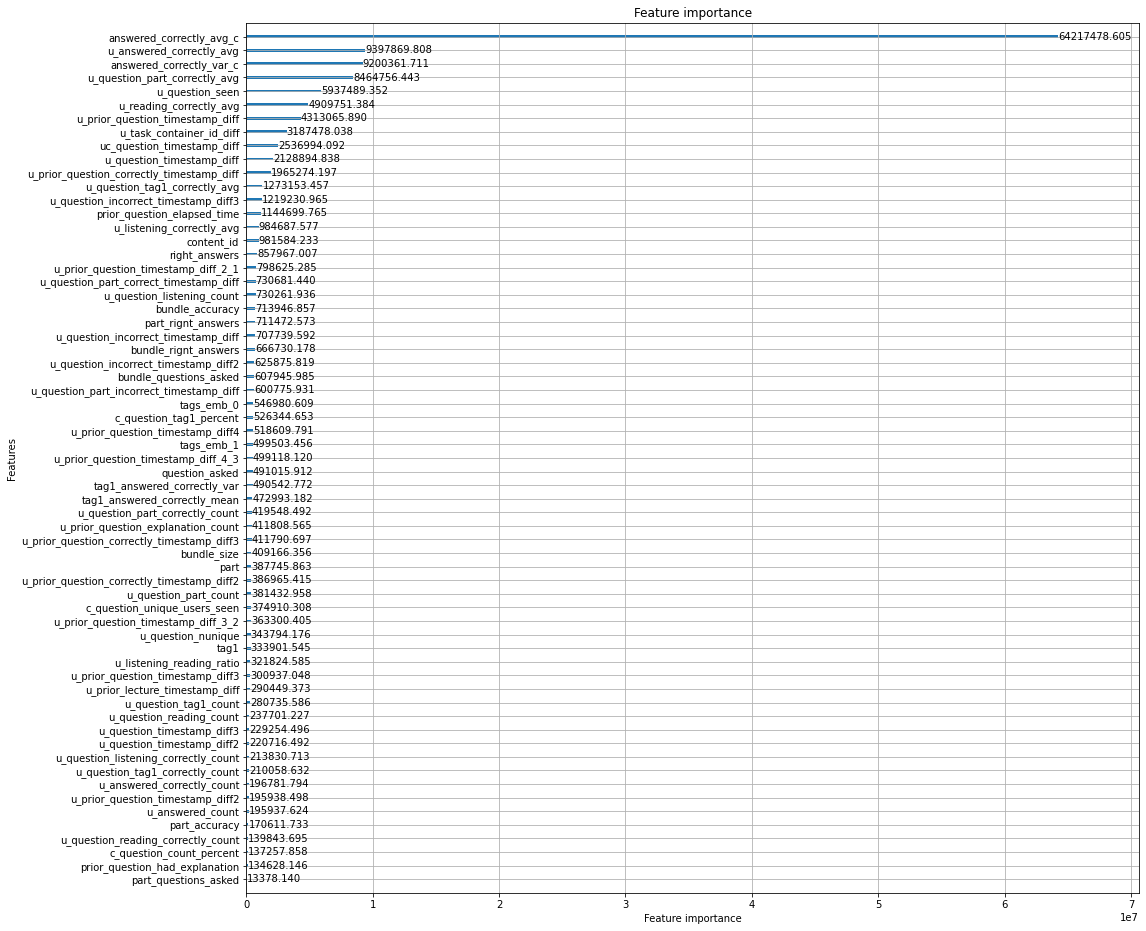

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16, 16)
lgb.plot_importance(model, importance_type='gain')

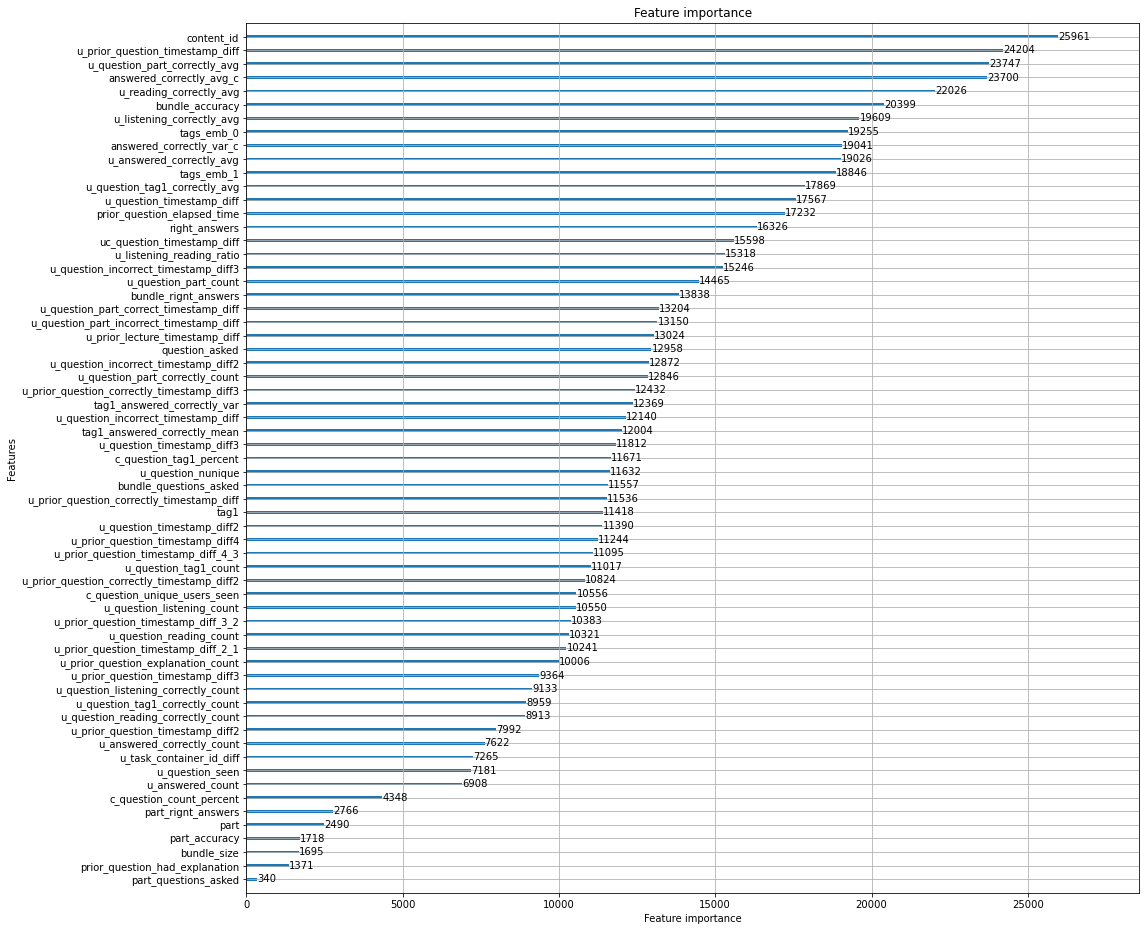

In [33]:
plt.rcParams["figure.figsize"] = (16, 16)
lgb.plot_importance(model, importance_type='split')

In [34]:
# 检查推理阶段是否正常 (重点看 index=4 和 index=11)

test_df = pd.read_csv('/home/user01/kaggle/riiid/example_test.csv')
test_df = test_df[test_df['content_type_id'] == 0].reset_index(drop=True)
test_df['prior_question_had_explanation'] = test_df.prior_question_had_explanation.fillna(False).astype('int8')
test_df = pd.merge(test_df, questions_df, on='content_id', how='left')
test_df = pd.merge(test_df, content_df, on='content_id',  how='left')
test_df['prior_question_elapsed_time'] = test_df.prior_question_elapsed_time.fillna(prior_question_elapsed_time_mean)
test_df.fillna(-1, inplace=True)
use_cols = ['user_id', 'content_type_id', 'part', 'tag1',
            'timestamp', 'task_container_id', 'prior_question_had_explanation', 
            'LorR', 'content_id']
test_df[use_cols] = test_df[use_cols].astype('int')
test_df = add_user_feats_without_update(test_df,
                                        u_answered_correctly_count_dict, 
                                        u_answered_count_dict, 
                                        u_question_part_correctly_count_dict,
                                        u_question_part_count_dict,
                                        u_question_tag1_correctly_count_dict,
                                        u_question_tag1_count_dict,
                                        u_prior_question_correctly_timestamp_dict,
                                        u_prior2_question_correctly_timestamp_dict,
                                        u_prior3_question_correctly_timestamp_dict,
                                        u_prior_question_timestamp_dict,
                                        u_prior2_question_timestamp_dict,
                                        u_prior3_question_timestamp_dict,
                                        u_prior4_question_timestamp_dict,
                                        u_prior_lecture_timestamp_dict,
                                        u_prior2_lecture_timestamp_dict,
                                        u_task_container_id_dict,
                                        u_prior_question_explanation_count_dict,
                                        u_prior_question_explanation_correctly_count_dict,
                                        u_question_listening_correctly_count_dict, 
                                        u_question_reading_correctly_count_dict,
                                        u_question_listening_count_dict, 
                                        u_question_reading_count_dict,
                                        u_question_incorrect_timestamp_dict,
                                        u_question_incorrect_timestamp2_dict,
                                        u_question_incorrect_timestamp3_dict,
                                        u_question_seen_dict,
                                        u_question_part_correct_timestamp_dict, 
                                        u_question_part_incorrect_timestamp_dict)
test_df[TARGET] = model.predict(test_df[FEATS])

test_df[['row_id', TARGET]].head(30)

,row_id,answered_correctly
0,0,0.400318
1,1,0.871046
2,2,0.656222
3,3,0.853126
4,4,0.301258
5,5,0.666266
6,6,0.519784
7,7,0.510012
8,8,0.743665
9,9,0.511642


In [35]:
# 保存到上传目录

upload_dir = './upload_cache_new'

# Kaggle 上的 pickle.HIGHEST_PROTOCOL = 4

content_df.to_pickle(f'{upload_dir}/content_df.pickle', protocol=4)
questions_df.to_pickle(f'{upload_dir}/questions_df.pickle', protocol=4)

model.save_model(f'{upload_dir}/lgb_model.txt')

import pickle   # Kaggle 上的 pickle.HIGHEST_PROTOCOL = 4
    
with open(f'{upload_dir}/u_question_seen_dict.pickle', 'wb') as handle:
    pickle.dump(u_question_seen_dict, handle, protocol=4)

with open(f'{upload_dir}/u_answered_correctly_count_dict.pickle', 'wb') as handle:
    pickle.dump(u_answered_correctly_count_dict, handle, protocol=4)
    
with open(f'{upload_dir}/u_answered_count_dict.pickle', 'wb') as handle:
    pickle.dump(u_answered_count_dict, handle, protocol=4)
    
with open(f'{upload_dir}/u_question_part_correctly_count_dict.pickle', 'wb') as handle:
    pickle.dump(u_question_part_correctly_count_dict, handle, protocol=4)
    
with open(f'{upload_dir}/u_question_part_count_dict.pickle', 'wb') as handle:
    pickle.dump(u_question_part_count_dict, handle, protocol=4)
    
with open(f'{upload_dir}/u_question_tag1_correctly_count_dict.pickle', 'wb') as handle:
    pickle.dump(u_question_tag1_correctly_count_dict, handle, protocol=4)
    
with open(f'{upload_dir}/u_question_tag1_count_dict.pickle', 'wb') as handle:
    pickle.dump(u_question_tag1_count_dict, handle, protocol=4)  

with open(f'{upload_dir}/u_prior_question_correctly_timestamp_dict.pickle', 'wb') as handle:
    pickle.dump(u_prior_question_correctly_timestamp_dict, handle, protocol=4) 
    
with open(f'{upload_dir}/u_prior2_question_correctly_timestamp_dict.pickle', 'wb') as handle:
    pickle.dump(u_prior2_question_correctly_timestamp_dict, handle, protocol=4) 
    
with open(f'{upload_dir}/u_prior3_question_correctly_timestamp_dict.pickle', 'wb') as handle:
    pickle.dump(u_prior3_question_correctly_timestamp_dict, handle, protocol=4) 
    
with open(f'{upload_dir}/u_prior_question_timestamp_dict.pickle', 'wb') as handle:
    pickle.dump(u_prior_question_timestamp_dict, handle, protocol=4)
    
with open(f'{upload_dir}/u_prior2_question_timestamp_dict.pickle', 'wb') as handle:
    pickle.dump(u_prior2_question_timestamp_dict, handle, protocol=4)
    
with open(f'{upload_dir}/u_prior3_question_timestamp_dict.pickle', 'wb') as handle:
    pickle.dump(u_prior3_question_timestamp_dict, handle, protocol=4)
    
with open(f'{upload_dir}/u_prior4_question_timestamp_dict.pickle', 'wb') as handle:
    pickle.dump(u_prior4_question_timestamp_dict, handle, protocol=4)
    
with open(f'{upload_dir}/u_prior_lecture_timestamp_dict.pickle', 'wb') as handle:
    pickle.dump(u_prior_lecture_timestamp_dict, handle, protocol=4)
    
with open(f'{upload_dir}/u_prior2_lecture_timestamp_dict.pickle', 'wb') as handle:
    pickle.dump(u_prior2_lecture_timestamp_dict, handle, protocol=4)
    
with open(f'{upload_dir}/u_task_container_id_dict.pickle', 'wb') as handle:
    pickle.dump(u_task_container_id_dict, handle, protocol=4)
    
with open(f'{upload_dir}/u_prior_question_explanation_count_dict.pickle', 'wb') as handle:
    pickle.dump(u_prior_question_explanation_count_dict, handle, protocol=4)
    
with open(f'{upload_dir}/u_prior_question_explanation_correctly_count_dict.pickle', 'wb') as handle:
    pickle.dump(u_prior_question_explanation_correctly_count_dict, handle, protocol=4)
    
with open(f'{upload_dir}/u_question_listening_correctly_count_dict.pickle', 'wb') as handle:
    pickle.dump(u_question_listening_correctly_count_dict, handle, protocol=4)
    
with open(f'{upload_dir}/u_question_reading_correctly_count_dict.pickle', 'wb') as handle:
    pickle.dump(u_question_reading_correctly_count_dict, handle, protocol=4)
    
with open(f'{upload_dir}/u_question_listening_count_dict.pickle', 'wb') as handle:
    pickle.dump(u_question_listening_count_dict, handle, protocol=4)
    
with open(f'{upload_dir}/u_question_reading_count_dict.pickle', 'wb') as handle:
    pickle.dump(u_question_reading_count_dict, handle, protocol=4)
    
with open(f'{upload_dir}/u_question_incorrect_timestamp_dict.pickle', 'wb') as handle:
    pickle.dump(u_question_incorrect_timestamp_dict, handle, protocol=4)
    
with open(f'{upload_dir}/u_question_incorrect_timestamp2_dict.pickle', 'wb') as handle:
    pickle.dump(u_question_incorrect_timestamp2_dict, handle, protocol=4)
    
with open(f'{upload_dir}/u_question_incorrect_timestamp3_dict.pickle', 'wb') as handle:
    pickle.dump(u_question_incorrect_timestamp3_dict, handle, protocol=4)
    
with open(f'{upload_dir}/u_question_part_correct_timestamp_dict.pickle', 'wb') as handle:
    pickle.dump(u_question_part_correct_timestamp_dict, handle, protocol=4)
    
with open(f'{upload_dir}/u_question_part_incorrect_timestamp_dict.pickle', 'wb') as handle:
    pickle.dump(u_question_part_incorrect_timestamp_dict, handle, protocol=4)
    
with open(f'{upload_dir}/uc_cache.pickle', 'wb') as handle:
    pickle.dump(lru_cache, handle, protocol=4)

In [36]:
!ls -lh {upload_dir}

total 2.2G
-rw-rw-r-- 1 user01 user01 530K Jan  2 07:52 content_df.pickle
-rw-rw-r-- 1 user01 user01  124 Jan  1 07:54 dataset-metadata.json
-rw-rw-r-- 1 user01 user01  88M Jan  2 07:52 lgb_model.txt
-rw-rw-r-- 1 user01 user01 2.4M Jan  2 07:52 questions_df.pickle
-rw-rw-r-- 1 user01 user01  15M Jan  2 07:52 u_answered_correctly_count_dict.pickle
-rw-rw-r-- 1 user01 user01 8.0M Jan  2 07:52 u_answered_count_dict.pickle
-rw-rw-r-- 1 user01 user01 7.9M Jan  2 07:55 u_prior2_lecture_timestamp_dict.pickle
-rw-rw-r-- 1 user01 user01  15M Jan  2 07:54 u_prior2_question_correctly_timestamp_dict.pickle
-rw-rw-r-- 1 user01 user01  15M Jan  2 07:54 u_prior2_question_timestamp_dict.pickle
-rw-rw-r-- 1 user01 user01  15M Jan  2 07:54 u_prior3_question_correctly_timestamp_dict.pickle
-rw-rw-r-- 1 user01 user01  15M Jan  2 07:55 u_prior3_question_timestamp_dict.pickle
-rw-rw-r-- 1 user01 user01  15M Jan  2 07:55 u_prior4_question_timestamp_dict.pickle
-rw-rw-r-- 1 user01 user01 7.9M Jan  2 07:55 u_p